## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_1206-0207-2023.csv', firstRow=594, lastRow=600)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_120623_S595-600.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=54s and ended at t=488s; mass=44.63805g
This equals a volume of 44.728m; expected was 44.8mL; error is 0.162%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.00125 g/s and for 2nd derivative = 0.00037499999999999995 g/s^2


<IPython.core.display.Javascript object>


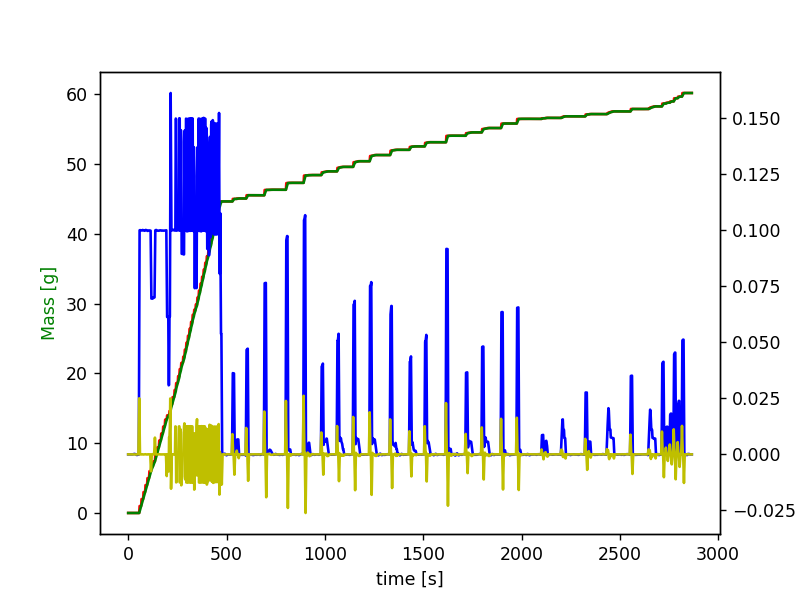

Addition of 0.427g Texapon SB 3 KC detected from 526s to 568s - expected volume = 0.501mL and actual volume = 0.385mL (resulting error is 23.153%)
Addition of 0.467g Texapon SB 3 KC detected from 596s to 616s - expected volume = 0.501mL and actual volume = 0.421mL (resulting error is 15.946%)
Addition of 0.795g Texapon SB 3 KC detected from 688s to 730s - expected volume = 0.962mL and actual volume = 0.716mL (resulting error is 25.59%)
Addition of 0.995g Plantapon ACG 50 detected from 798s to 830s - expected volume = 0.941mL and actual volume = 0.882mL (resulting error is 6.23%)
Addition of 1.117g Plantapon ACG 50 detected from 888s to 930s - expected volume = 0.908mL and actual volume = 0.99mL (resulting error is 8.966%)
Addition of 0.534g Plantapon LC 7 detected from 978s to 1022s - expected volume = 0.592mL and actual volume = 0.505mL (resulting error is 14.701%)
Addition of 0.647g Plantapon LC 7 detected from 1058s to 1100s - expected volume = 0.592mL and actual volume = 0.611mL (r

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0015625 g/s and for 2nd derivative = 0.000390625 g/s^2


<IPython.core.display.Javascript object>


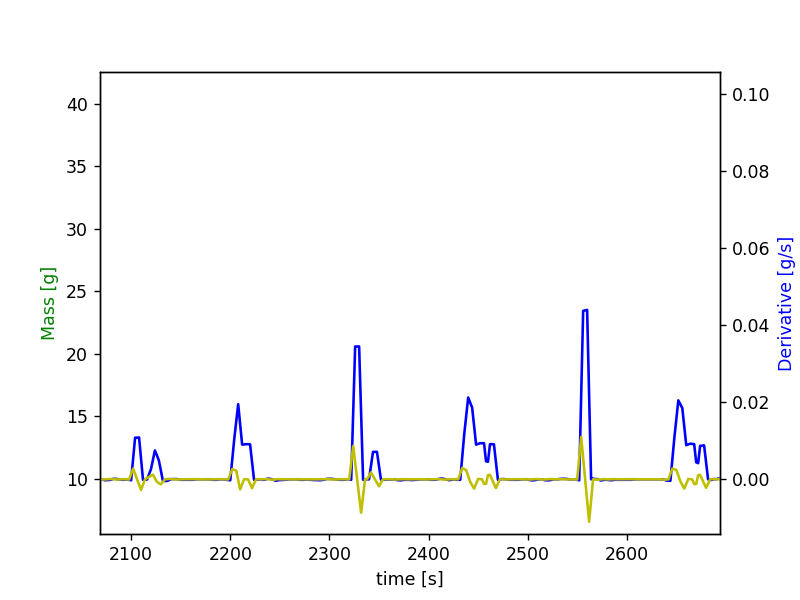

Addition of 0.142g Dehyquart CC6 detected from 2098s to 2136s - expected volume = 0.098mL and actual volume = 0.136mL (resulting error is 37.985%)
Addition of 0.226g Dehyquart CC6 detected from 2198s to 2228s - expected volume = 0.184mL and actual volume = 0.214mL (resulting error is 16.559%)
Addition of 0.331g Dehyquart CC6 detected from 2320s to 2356s - expected volume = 0.279mL and actual volume = 0.315mL (resulting error is 13.097%)
Addition of 0.388g Dehyquart CC6 detected from 2430s to 2474s - expected volume = 0.243mL and actual volume = 0.37mL (resulting error is 52.353%)
Addition of 0.35g Dehyquart CC6 detected from 2550s to 2568s - expected volume = 0.217mL and actual volume = 0.334mL (resulting error is 53.618%)
Addition of 0.375g Dehyquart CC6 detected from 2642s to 2686s - expected volume = 0.235mL and actual volume = 0.356mL (resulting error is 51.058%)


In [4]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2014,2112,2210,2314,2412,2494,2564])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


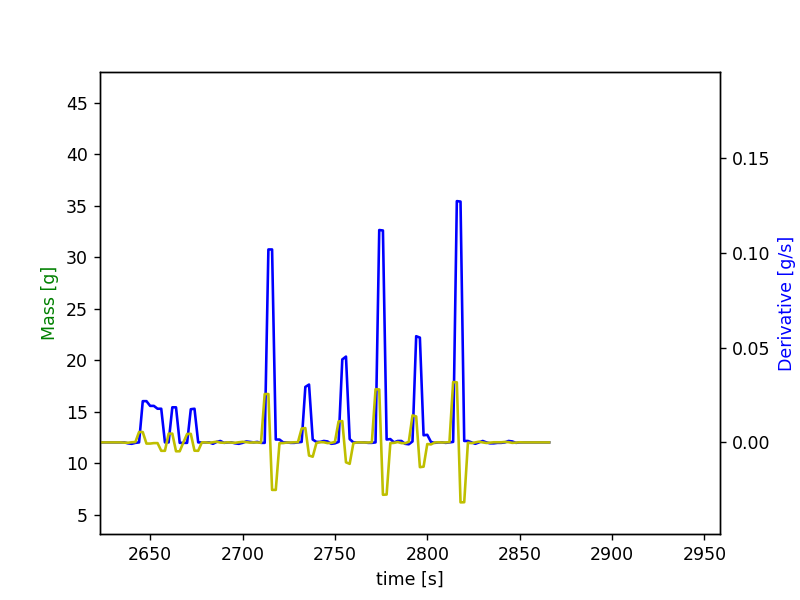

Addition of 0.413g Arlypon F detected from 2710s to 2722s - expected volume = 0.463mL and actual volume = 0.473mL (resulting error is 2.104%)
Addition of 0.123g Arlypon F detected from 2730s to 2742s - expected volume = 0.124mL and actual volume = 0.141mL (resulting error is 13.303%)
Addition of 0.179g Arlypon F detected from 2750s to 2762s - expected volume = 0.189mL and actual volume = 0.206mL (resulting error is 8.788%)
Addition of 0.453g Arlypon F detected from 2770s to 2782s - expected volume = 0.494mL and actual volume = 0.52mL (resulting error is 5.104%)
Addition of 0.236g Arlypon F detected from 2790s to 2802s - expected volume = 0.245mL and actual volume = 0.27mL (resulting error is 10.28%)
Addition of 0.511g Arlypon F detected from 2812s to 2824s - expected volume = 0.562mL and actual volume = 0.584mL (resulting error is 3.963%)


In [5]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2600,2616,2636,2656,2676,2884,2906])

## Consolidate results and create output

In [6]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_120623_S595-S600.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_26272\1116399738.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
594,595.0,8.987359,0.000000,0.000000,0.000000,10.96498,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.430379,0.0,0.0,4.151496,0.0
595,596.0,0.000000,0.000000,11.691181,0.000000,0.00000,0.000000,0.0,0.000000,13.123763,0.0,0.0,0.0,0.0,2.237174,0.0,0.0,1.221851,0.0
596,597.0,7.997178,0.000000,8.151144,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,3.334673,0.0,0.0,1.806334,0.0
597,598.0,0.000000,9.875294,0.000000,7.493074,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,3.856218,0.0,0.0,4.496440,0.0
598,599.0,0.000000,10.722811,8.565577,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,3.362579,0.0,0.0,2.265721,0.0
599,600.0,0.000000,0.000000,0.000000,0.000000,0.00000,9.360002,0.0,11.017855,0.000000,0.0,0.0,0.0,0.0,3.727930,0.0,0.0,5.089986,0.0
